In [ ]:
import numpy as np 
import pandas as pd 
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os
import zipfile
from tensorflow.keras.utils import to_categorical

In [ ]:
#!pip install visualkeras
#import visualkeras

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kerembalc","key":"c746f2baa96ef14bd23edd7ad971f654"}'}

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 1.28G/1.28G [00:08<00:00, 256MB/s]
100% 1.28G/1.28G [00:08<00:00, 164MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('fruits.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /content folder
zip_ref.close()

In [ ]:
training_fruit_img = []
training_label = []
for dir_path in glob.glob("../content/*/fruits-360/Training/*"):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        training_fruit_img.append(image)
        training_label.append(img_label)
training_fruit_img = np.array(training_fruit_img)
training_label = np.array(training_label)

In [ ]:
label_to_id = {v:k for k,v in enumerate(np.unique(training_label)) }
id_to_label = {v:k for k,v in label_to_id.items() }

In [ ]:
id_to_label

In [ ]:
training_label_id = np.array([label_to_id[i] for i in training_label])

In [ ]:
training_label_id

array([38, 38, 38, ..., 86, 86, 86])

In [ ]:
training_fruit_img.shape,training_label_id.shape

((67692, 32, 32, 3), (67692,))

In [ ]:
test_image=[]
test_label =[]
for dir_path in glob.glob("../content/*/fruits-360/Test/*"):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        test_image.append(image)
        test_label.append(img_label)
test_image = np.array(test_image)
test_label = np.array(test_label)

In [ ]:
test_label_id = np.array([label_to_id[i] for i in test_label])

In [ ]:
test_image.shape,test_label_id.shape


((22688, 32, 32, 3), (22688,))

In [ ]:
X_train,X_test = training_fruit_img,test_image
y_train,y_test =training_label_id,test_label_id

X_train = X_train/255
X_test = X_test/255

In [ ]:
y_test

array([38, 38, 38, ..., 86, 86, 86])

In [ ]:
##X_flat_train = X_train.reshape(X_train.shape[0],32*32*3)
##X_flat_test = X_test.reshape(X_test.shape[0],32*32*3)

#One Hot Encode the Output
y_train = keras.utils.np_utils.to_categorical(y_train,131)
y_test = keras.utils.np_utils.to_categorical(y_test,131) ##????

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
print('Original Sizes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print('Flattened:', X_flat_train.shape, X_flat_test.shape)

Original Sizes: (67692, 32, 32, 3) (22688, 32, 32, 3) (67692, 131) (22688, 131)


(32, 32, 3)


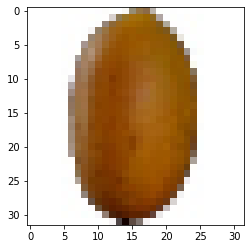

In [ ]:
print(X_train[1000].shape)
plt.imshow(X_train[100])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

In [ ]:
X_train,val_images,y_train,val_labels = train_test_split(X_train,y_train,test_size=0.15,random_state=1)

In [ ]:
#MLP
model1 = Sequential();

model1.add(Flatten(input_shape=(32,32,3)))
model1.add(Dense(256,activation="relu"))
model1.add(Dropout(0.1))
model1.add(Dense(128,activation="relu"))

model1.add(Dense(131,activation="softmax"))
earlystopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 131)               16899     
                                                                 
Total params: 836,483
Trainable params: 836,483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer="sgd",loss='categorical_crossentropy' ,metrics=['accuracy'])   

history = model1.fit(X_train,y_train,epochs = 25,validation_data= (val_images,val_labels),batch_size=128,callbacks=[earlystopCB])

Epoch 1/25
450/450 [==============================] - 8s 16ms/step - loss: 4.4472 - accuracy: 0.0666 - val_loss: 3.7362 - val_accuracy: 0.1923
Epoch 2/25
450/450 [==============================] - 7s 15ms/step - loss: 2.9742 - accuracy: 0.3012 - val_loss: 2.1497 - val_accuracy: 0.5433
Epoch 3/25
450/450 [==============================] - 7s 16ms/step - loss: 1.8612 - accuracy: 0.5328 - val_loss: 1.3859 - val_accuracy: 0.6957
Epoch 4/25
450/450 [==============================] - 7s 15ms/step - loss: 1.2853 - accuracy: 0.6723 - val_loss: 0.9877 - val_accuracy: 0.7764
Epoch 5/25
450/450 [==============================] - 7s 15ms/step - loss: 0.9602 - accuracy: 0.7554 - val_loss: 0.7232 - val_accuracy: 0.8423
Epoch 6/25
450/450 [==============================] - 7s 15ms/step - loss: 0.7539 - accuracy: 0.8071 - val_loss: 0.5825 - val_accuracy: 0.8669
Epoch 7/25
450/450 [==============================] - 7s 15ms/step - loss: 0.6136 - accuracy: 0.8424 - val_loss: 0.4641 - val_accuracy: 0.8932

In [ ]:
test_loss,test_acc = model1.evaluate(X_test,y_test)

709/709 [==============================] - 3s 3ms/step - loss: 0.3585 - accuracy: 0.8952


[Text(0.5, 0, 'Epochs')]

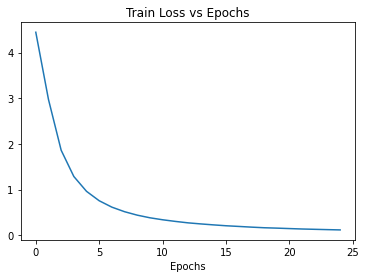

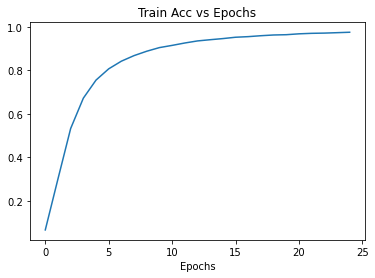

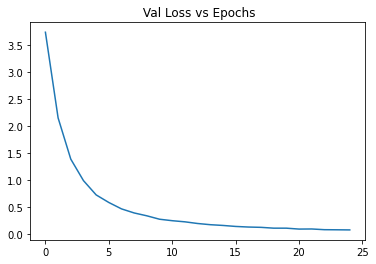

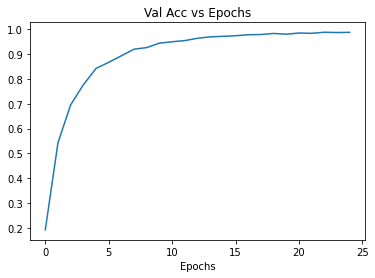

In [ ]:
df = pd.DataFrame(history.history)
df.head()
loss_plot = df.plot(y = 'loss' , title = 'Train Loss vs Epochs', legend= False)
loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'accuracy' , title = 'Train Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

loss_plot = df.plot(y = 'val_loss' , title = ' Val Loss vs Epochs', legend= False)
#loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'val_accuracy' , title = 'Val Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

In [ ]:
# CNN Model 1 - LeNet
model2 = Sequential()

model2.add(Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())

model2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())

model2.add(Flatten())

model2.add(Dense(120, activation='relu'))
model2.add(Dropout(0.2)) ###

model2.add(Dense(units=84, activation='relu'))

model2.add(Dense(units=131, activation = 'softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         168       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 16)       64        
 hNormalization)                                                 
                                                      

In [ ]:
model2.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

history = model2.fit(X_train,y_train,batch_size=128,epochs=10,verbose=1,validation_data = (val_images,val_labels))

Epoch 1/10
450/450 [==============================] - 44s 97ms/step - loss: 1.1348 - accuracy: 0.7162 - val_loss: 1.4724 - val_accuracy: 0.6192
Epoch 2/10
450/450 [==============================] - 43s 96ms/step - loss: 0.1234 - accuracy: 0.9624 - val_loss: 0.0336 - val_accuracy: 0.9922
Epoch 3/10
450/450 [==============================] - 43s 96ms/step - loss: 0.0619 - accuracy: 0.9812 - val_loss: 0.0165 - val_accuracy: 0.9968
Epoch 4/10
450/450 [==============================] - 43s 96ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0111 - val_accuracy: 0.9968
Epoch 5/10
450/450 [==============================] - 43s 97ms/step - loss: 0.0370 - accuracy: 0.9883 - val_loss: 0.0206 - val_accuracy: 0.9921
Epoch 6/10
450/450 [==============================] - 44s 97ms/step - loss: 0.0301 - accuracy: 0.9906 - val_loss: 0.0322 - val_accuracy: 0.9883
Epoch 7/10
450/450 [==============================] - 43s 96ms/step - loss: 0.0315 - accuracy: 0.9900 - val_loss: 0.0078 - val_accuracy:

In [ ]:
score = model2.evaluate(X_test, y_test)
print('Test loss:', score[0],'    Test accuracy:', score[1])

709/709 [==============================] - 8s 11ms/step - loss: 0.3374 - accuracy: 0.9286
Test loss: 0.3373989760875702     Test accuracy: 0.9285966157913208


[Text(0.5, 0, 'Epochs')]

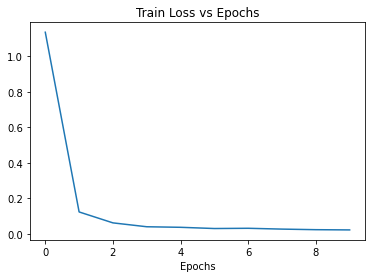

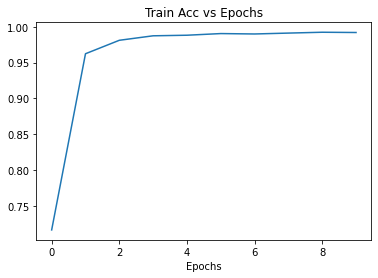

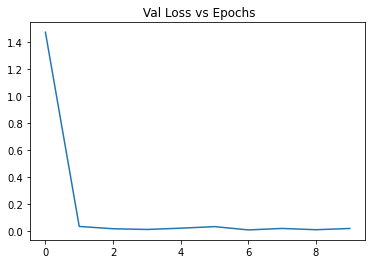

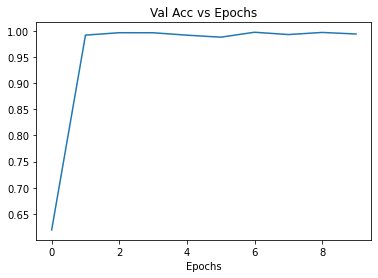

In [ ]:
df = pd.DataFrame(history.history)
df.head()
loss_plot = df.plot(y = 'loss' , title = 'Train Loss vs Epochs', legend= False)
loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'accuracy' , title = 'Train Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

loss_plot = df.plot(y = 'val_loss' , title = ' Val Loss vs Epochs', legend= False)
#loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'val_accuracy' , title = 'Val Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

In [ ]:
# CNN Model 2
model3 = Sequential()
model3.add(Conv2D(16,(3,3),input_shape=(32,32,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(256,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(131,activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
model3.compile(loss='categorical_crossentropy',optimizer = 'sgd',metrics=['accuracy'])

history=model3.fit(X_train,y_train,batch_size=128,epochs=7,verbose=1,validation_data = (val_images,val_labels),shuffle=True)

Epoch 1/7
450/450 [==============================] - 81s 179ms/step - loss: 2.1859 - accuracy: 0.5269 - val_loss: 1.4066 - val_accuracy: 0.7622
Epoch 2/7
450/450 [==============================] - 79s 175ms/step - loss: 0.4443 - accuracy: 0.9058 - val_loss: 0.2253 - val_accuracy: 0.9672
Epoch 3/7
450/450 [==============================] - 79s 175ms/step - loss: 0.1891 - accuracy: 0.9646 - val_loss: 0.0711 - val_accuracy: 0.9935
Epoch 4/7
450/450 [==============================] - 79s 176ms/step - loss: 0.1072 - accuracy: 0.9825 - val_loss: 0.0422 - val_accuracy: 0.9961
Epoch 5/7
450/450 [==============================] - 78s 173ms/step - loss: 0.0721 - accuracy: 0.9895 - val_loss: 0.0340 - val_accuracy: 0.9956
Epoch 6/7
450/450 [==============================] - 78s 174ms/step - loss: 0.0528 - accuracy: 0.9925 - val_loss: 0.0175 - val_accuracy: 0.9990
Epoch 7/7
450/450 [==============================] - 79s 175ms/step - loss: 0.0411 - accuracy: 0.9950 - val_loss: 0.0168 - val_accuracy:

In [ ]:
score = model3.evaluate(X_test, y_test)
print('Test loss:', score[0],'    Test accuracy:', score[1])

709/709 [==============================] - 11s 15ms/step - loss: 0.2253 - accuracy: 0.9449
Test loss: 0.22528530657291412     Test accuracy: 0.9448606967926025


[Text(0.5, 0, 'Epochs')]

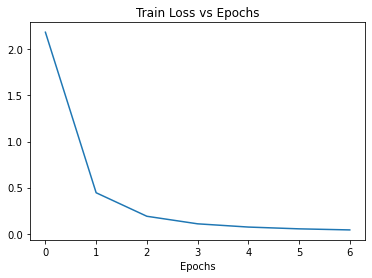

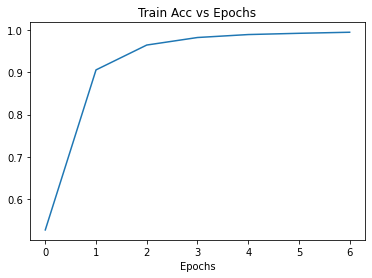

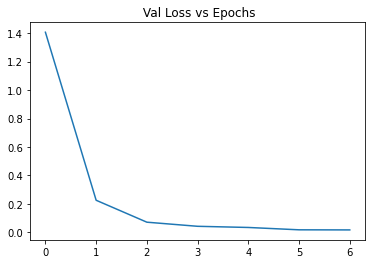

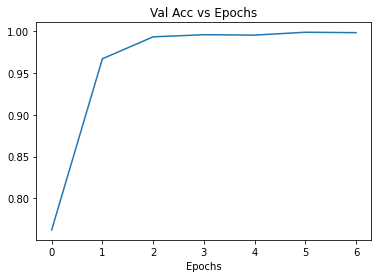

In [ ]:
df = pd.DataFrame(history.history)
df.head()
loss_plot = df.plot(y = 'loss' , title = 'Train Loss vs Epochs', legend= False)
loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'accuracy' , title = 'Train Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

loss_plot = df.plot(y = 'val_loss' , title = ' Val Loss vs Epochs', legend= False)
#loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'val_accuracy' , title = 'Val Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')